In [1]:
import numpy as np
import pandas as pd
import os
import csv
import ast
import seaborn as sns
from matplotlib import pyplot as plt
import wquantiles 

from tqdm import tqdm
from wquantiles import quantile
from openfisca_survey_manager.utils import asof

from openfisca_france_indirect_taxation import FranceIndirectTaxationTaxBenefitSystem
from openfisca_france_indirect_taxation.surveys import SurveyScenario
from openfisca_france_indirect_taxation.examples.utils_example import (
    dataframe_by_group,
    df_weighted_average_grouped,
    wavg)
from openfisca_france_indirect_taxation.build_survey_data.utils import weighted_sum
from openfisca_france_indirect_taxation.projects.TVA_Herve_IPP.new_calage_bdf_cn import new_get_inflators_by_year
from openfisca_france_indirect_taxation.projects.TVA_Herve_IPP.Utils import weighted_quantiles, stacked_bar_plot, bootstrap_weighted_mean_by_decile
from openfisca_france_indirect_taxation.utils import assets_directory, get_input_data_frame


In [2]:
simulated_variables = ['depenses_tva_taux_plein',
'depenses_tva_taux_intermediaire',
'depenses_tva_taux_reduit',
'depenses_tva_taux_super_reduit',
'depenses_ht_tva_taux_plein',
'depenses_ht_tva_taux_intermediaire',
'depenses_ht_tva_taux_reduit',
'depenses_ht_tva_taux_super_reduit',
'depenses_tva_exonere',
'depenses_totales',
'depenses_tot',
'tva_total',
'rev_disponible',
 'niveau_de_vie',
 'niveau_vie_decile',
 'ocde10',
 'pondmen',
 'nactifs',
 'npers',
 'identifiant_menage']

In [3]:
data = {"quantile_indiv_niveau_vie": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'rev_disponible_taxipp' : [
        17164,
        28523,
        32785,
        37962,
        42484,
        47179,
        53571,
        60538,
        72271,
        121762,
    ],
    'niveau_de_vie_taxipp' : [
        8082,
        14242,
        17617,
        20598,
        23339,
        26229,
        29506,
        33734,
        40382,
        69374
    ]
}
df_taxipp = pd.DataFrame(data)

In [4]:
year = 2024
data_year = 2017
tax_benefit_system = FranceIndirectTaxationTaxBenefitSystem()
inflators_by_year = new_get_inflators_by_year(rebuild = False, year_range = range(2017, 2025), data_year = data_year)
inflation_kwargs = dict(inflator_by_variable = inflators_by_year[year])

survey_scenario = SurveyScenario.create(
    inflation_kwargs =  inflation_kwargs,
    tax_benefit_system = tax_benefit_system,
    year = year,
    data_year = data_year
)

In [5]:
# On se place au niveau individu (en dupliquant les observations de chaque ménage) et on calcule des déciles de niveau de vie individuels

baseline_menage = survey_scenario.create_data_frame_by_entity(simulated_variables, filter_by = 'rev_disponible > 0', period = 2024)['menage']
baseline_indiv = baseline_menage.loc[baseline_menage.index.repeat(baseline_menage['npers'])]
baseline_indiv['quantile_indiv_niveau_vie'] = weighted_quantiles(baseline_indiv['niveau_de_vie'], labels = np.arange(1,11), weights = baseline_indiv['pondmen'], return_quantiles= False)
baseline_indiv['quantile_indiv_niveau_vie'] = baseline_indiv['quantile_indiv_niveau_vie'].astype(int)

df_decile_indiv = baseline_indiv[['identifiant_menage','quantile_indiv_niveau_vie']].drop_duplicates() # On garde le lien identifiant ménage - quantil_indiv_niveau_vie 

baseline_by_decile = df_weighted_average_grouped(dataframe = baseline_indiv, 
                                                   groupe = 'quantile_indiv_niveau_vie', 
                                                   varlist = ['rev_disponible','niveau_de_vie']
                                                    )

baseline_by_decile = baseline_by_decile.merge(df_taxipp, how = 'inner', on = 'quantile_indiv_niveau_vie')
baseline_by_decile['coeff_calage'] = baseline_by_decile['rev_disponible_taxipp'] / baseline_by_decile['rev_disponible']


In [6]:
# On recale les revenus disponible dans les données qui serviront d'entrée au modèle 
input_data_frame = get_input_data_frame(2017)
input_data_frame = input_data_frame.merge(df_decile_indiv, how = 'right', on = 'identifiant_menage')
input_data_frame = input_data_frame.merge(baseline_by_decile[['quantile_indiv_niveau_vie','coeff_calage']], how = 'left', on = 'quantile_indiv_niveau_vie')
input_data_frame['rev_disponible'] = input_data_frame['rev_disponible'] * input_data_frame['coeff_calage']
input_data_frame.drop(['quantile_indiv_niveau_vie','coeff_calage'], axis = 1, inplace = True)

## Recalage sur les 13 Milliards
On recale également les dépenses pour atteindre un montant de dépenses hors-taxes de 60,5% de 1 300 Milliards. De sorte que le rendement du point de TVA soit de 13 Milliards

In [7]:
depenses_ht_totales = (survey_scenario.compute_aggregate(variable = 'depenses_ht_tva_taux_plein', period = year) +
 survey_scenario.compute_aggregate(variable = 'depenses_ht_tva_taux_intermediaire', period = year) + 
 survey_scenario.compute_aggregate(variable = 'depenses_ht_tva_taux_reduit', period = year) + 
 survey_scenario.compute_aggregate(variable = 'depenses_ht_tva_taux_super_reduit', period = year)
 )
depenses_ht_totales
tva_total = survey_scenario.compute_aggregate(variable = 'tva_total', period = year)
emplois_taxables_tot = 13E11
part_conso_menages = 0.605
coeff = part_conso_menages * emplois_taxables_tot / depenses_ht_totales
coeff

0.8607480864846293

In [8]:
from openfisca_france_indirect_taxation.projects.TVA_Herve_IPP.Reform_TVA_budget_2025 import augmente_tous_les_taux_pass_through_0_8

# Simulation hausse d'un point de TVA avec pass-through de 0.8

In [9]:
new_inflators_2024 = { k:v if k in ['loyer_impute','rev_disp_yc_loyerimpute','rev_disponible'] else  v*coeff 
                      for k,v in inflators_by_year[2024].items()}
inflation_kwargs = dict(inflator_by_variable = new_inflators_2024)

tax_benefit_system = FranceIndirectTaxationTaxBenefitSystem()

survey_scenario = SurveyScenario.create(
    input_data_frame = input_data_frame, # La base d'entrée a des revenus disponibles / niveaux de vie calés sur ceux de taxipp
    inflation_kwargs =  inflation_kwargs,
    baseline_tax_benefit_system = tax_benefit_system,
    reform = augmente_tous_les_taux_pass_through_0_8,
    year = year,
    )

In [10]:
recolte_taux_plein = survey_scenario.compute_aggregate(variable='tva_taux_plein', filter_by = 'rev_disponible > 0', difference= True, period = year) * 1e-9
recolte_taux_inter = survey_scenario.compute_aggregate(variable='tva_taux_intermediaire', filter_by = 'rev_disponible > 0', difference= True, period = year) * 1e-9
recolte_taux_reduit = survey_scenario.compute_aggregate(variable='tva_taux_reduit', filter_by = 'rev_disponible > 0', difference= True, period = year) * 1e-9
recolte_taux_super_reduit = survey_scenario.compute_aggregate(variable='tva_taux_super_reduit', filter_by = 'rev_disponible > 0', difference= True, period = year) * 1e-9

In [11]:
recolte_taux_plein + recolte_taux_inter + recolte_taux_reduit + recolte_taux_super_reduit

7.653240041432567

In [12]:
baseline_menage = survey_scenario.create_data_frame_by_entity(simulated_variables, filter_by = 'rev_disponible > 0', use_baseline = True, period = 2024)['menage']
reform_menage   = survey_scenario.create_data_frame_by_entity(simulated_variables, filter_by = 'rev_disponible > 0', use_baseline = False, period = 2024)['menage']
difference_menage = pd.DataFrame()
baseline_variables = ['depenses_tot','rev_disponible','niveau_de_vie','niveau_vie_decile','ocde10','pondmen','nactifs','npers','identifiant_menage'] 
difference_menage[baseline_variables] = baseline_menage[baseline_variables]

difference_menage['depenses_totales'] = baseline_menage['depenses_totales'] - reform_menage['depenses_totales']
difference_menage['depenses_tot_par_uc'] = difference_menage['depenses_tot'] / difference_menage['ocde10']
difference_menage['depenses_totales_par_uc'] = difference_menage['depenses_totales'] / difference_menage['ocde10']

for taux in ['plein','intermediaire', 'reduit', 'super_reduit']:
    difference_menage['depenses_tva_taux_{}'.format(taux)] = baseline_menage['depenses_tva_taux_{}'.format(taux)] - reform_menage['depenses_tva_taux_{}'.format(taux)] 
difference_menage['actifs'] = (difference_menage['nactifs'] >= 1)

difference_indiv = difference_menage.loc[difference_menage.index.repeat(difference_menage['npers'])]
difference_indiv['quantile_indiv_niveau_vie'] = weighted_quantiles(difference_indiv['niveau_de_vie'], labels = np.arange(1,11), weights = difference_indiv['pondmen'], return_quantiles=False)
difference_indiv['quantile_indiv_niveau_vie'] = difference_indiv['quantile_indiv_niveau_vie'].astype(int)
difference_menage['npers'].sum(), len(difference_indiv)

(28533, 28533)

In [13]:
liste_taux = ['plein','intermediaire', 'reduit', 'super_reduit']
for taux in liste_taux:
   difference_indiv['depenses_par_uc_tva_taux_{}'.format(taux)] = difference_indiv['depenses_tva_taux_{}'.format(taux)] / difference_indiv['ocde10']

difference_by_decile = df_weighted_average_grouped(dataframe = difference_indiv, 
                                                   groupe = 'quantile_indiv_niveau_vie', 
                                                   varlist = ['depenses_tot','depenses_tot_par_uc','depenses_totales_par_uc',
                                                              'rev_disponible','niveau_de_vie'] +
                                                   ['depenses_par_uc_tva_taux_{}'.format(taux) for taux in liste_taux]
                                                    )
for taux in liste_taux:
   difference_by_decile['Taux_effort_tva_taux_{}'.format(taux)] = difference_by_decile['depenses_par_uc_tva_taux_{}'.format(taux)] / difference_by_decile['niveau_de_vie'] * 100
difference_by_decile['Taux_effort_total'] = difference_by_decile['depenses_totales_par_uc'] / difference_by_decile['niveau_de_vie'] * 100

In [14]:
df = difference_menage.merge(df_decile_indiv, how = 'left', on = 'identifiant_menage')
results_bootstrap_all = bootstrap_weighted_mean_by_decile(df, 'pondmen', 'quantile_indiv_niveau_vie', B = 10000)

errors_all = pd.DataFrame(pd.DataFrame(results_bootstrap_all).std(axis = 0))
errors_all = errors_all.reset_index().drop('index',axis = 1).rename({0 : 'std'},axis = 1)
errors_all = errors_all.reset_index().rename({'index' : 'quantile_indiv_niveau_vie'}, axis = 1).set_index('quantile_indiv_niveau_vie')
errors_all['errors'] = 1.96 * errors_all['std']
difference_by_decile = difference_by_decile.merge(errors_all, left_index = True, right_index = True)

  7%|▋         | 742/10000 [00:47<09:56, 15.53it/s]


KeyboardInterrupt: 

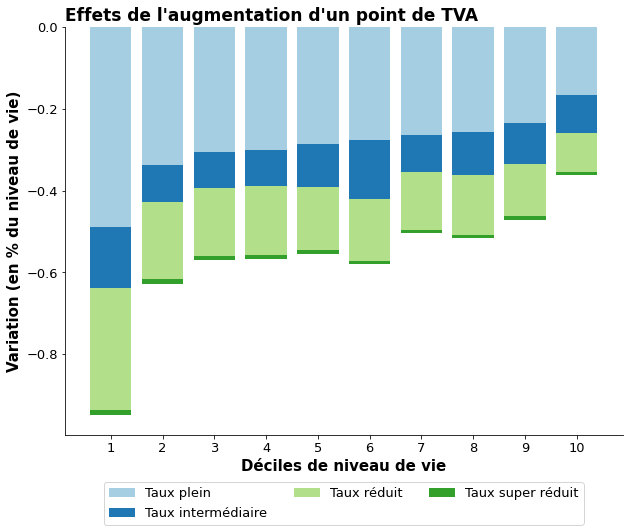

In [ ]:
stacked_bar_plot(difference_by_decile, 
                 variables = ['Taux_effort_tva_taux_{}'.format(taux) for taux in liste_taux],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                 title = "Effets de l'augmentation d'un point de TVA",
                 xlabel = 'Déciles de niveau de vie' ,
                 ylabel ='Variation (en % du niveau de vie)',
                 colors = list(sns.color_palette("Paired")),
                 savefig = True,
                 outfile = 'Taux_effort_pass_through_0_8.pdf',
                 errors = None
                 )

## Décomposition actifs / inactifs

In [15]:
difference_by_decile_actifs = df_weighted_average_grouped(dataframe = difference_indiv.loc[difference_indiv['actifs'] == 1], 
                                                   groupe = 'quantile_indiv_niveau_vie', 
                                                   varlist = ['depenses_tot','depenses_tot_par_uc','depenses_totales_par_uc',
                                                              'rev_disponible','niveau_de_vie'] +
                                                   ['depenses_par_uc_tva_taux_{}'.format(taux) for taux in liste_taux]
                                                    )
difference_by_decile_actifs['taux_epargne_actifs'] = 1 - difference_by_decile_actifs['depenses_tot'] / difference_by_decile_actifs['rev_disponible']

for taux in liste_taux:
   difference_by_decile_actifs['Taux_effort_tva_taux_{}'.format(taux)] = difference_by_decile_actifs['depenses_par_uc_tva_taux_{}'.format(taux)] / difference_by_decile_actifs['niveau_de_vie'] * 100
difference_by_decile_actifs['Taux_effort_total'] = difference_by_decile_actifs['depenses_totales_par_uc'] / difference_by_decile_actifs['niveau_de_vie'] * 100

In [ ]:
# Bootstrap 

results_bootstrap_actifs = bootstrap_weighted_mean_by_decile(df.loc[df['actifs'] == 1], 'pondmen', 'quantile_indiv_niveau_vie', B = 10000)
errors_actifs = pd.DataFrame(pd.DataFrame(results_bootstrap_actifs).std(axis = 0))
errors_actifs = errors_actifs.reset_index().drop('index',axis = 1).rename({0 : 'std'},axis = 1)
errors_actifs = errors_actifs.reset_index().rename({'index' : 'quantile_indiv_niveau_vie'}, axis = 1).set_index('quantile_indiv_niveau_vie')
errors_actifs['errors'] = 1.96 * errors_actifs['std']
difference_by_decile_actifs = difference_by_decile_actifs.merge(errors_actifs, left_index = True, right_index = True)

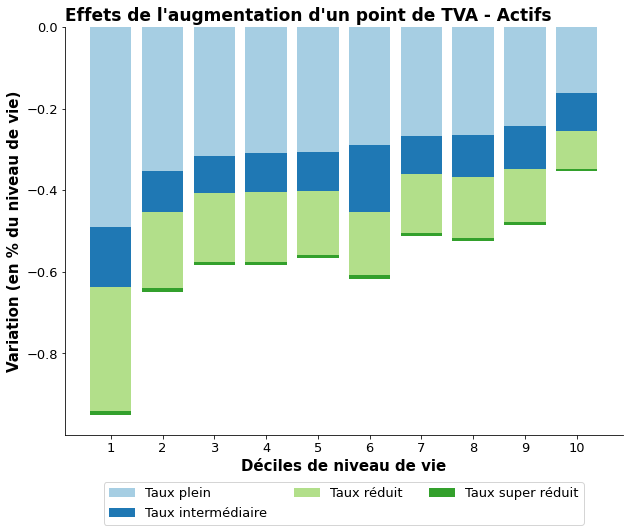

In [ ]:
stacked_bar_plot(difference_by_decile_actifs, 
                 variables = ['Taux_effort_tva_taux_{}'.format(taux) for taux in liste_taux],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                 title = "Effets de l'augmentation d'un point de TVA - Actifs",
                 xlabel = 'Déciles de niveau de vie' ,
                 ylabel ='Variation (en % du niveau de vie)',
                 colors = list(sns.color_palette("Paired")),
                 savefig = True,
                 outfile = 'Taux_effort_actifs_only_pass_through_0_8.pdf',
                 errors = None)

In [16]:
difference_by_decile_not_actifs = df_weighted_average_grouped(dataframe = difference_indiv.loc[difference_indiv['actifs'] == 0], 
                                                   groupe = 'quantile_indiv_niveau_vie', 
                                                   varlist = ['depenses_tot','depenses_tot_par_uc','depenses_totales_par_uc',
                                                              'rev_disponible','niveau_de_vie'] +
                                                   ['depenses_par_uc_tva_taux_{}'.format(taux) for taux in liste_taux],
                                                    )
difference_by_decile_not_actifs['taux_epargne_inactifs'] = 1 - difference_by_decile_not_actifs['depenses_tot'] / difference_by_decile_not_actifs['rev_disponible']

for taux in liste_taux:
   difference_by_decile_not_actifs['Taux_effort_tva_taux_{}'.format(taux)] = difference_by_decile_not_actifs['depenses_par_uc_tva_taux_{}'.format(taux)] / difference_by_decile_not_actifs['niveau_de_vie'] * 100
difference_by_decile_not_actifs['Taux_effort_total'] = difference_by_decile_not_actifs['depenses_totales_par_uc'] / difference_by_decile_not_actifs['niveau_de_vie'] * 100

In [ ]:
# Bootstrap 

results_bootstrap_inactifs = bootstrap_weighted_mean_by_decile(df.loc[df['actifs'] == 0], 'pondmen', 'quantile_indiv_niveau_vie', B = 10000)
errors_inactifs = pd.DataFrame(pd.DataFrame(results_bootstrap_inactifs).std(axis = 0))
errors_inactifs = errors_inactifs.reset_index().drop('index',axis = 1).rename({0 : 'std'},axis = 1)
errors_inactifs = errors_inactifs.reset_index().rename({'index' : 'quantile_indiv_niveau_vie'}, axis = 1).set_index('quantile_indiv_niveau_vie')
errors_inactifs['errors'] = 1.96 * errors_inactifs['std']
difference_by_decile_not_actifs = difference_by_decile_not_actifs.merge(errors_inactifs, left_index = True, right_index = True)

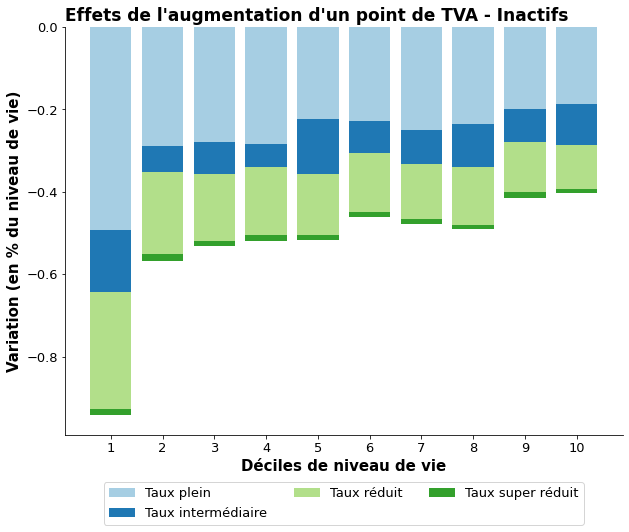

In [ ]:
stacked_bar_plot(difference_by_decile_not_actifs, 
                 variables = ['Taux_effort_tva_taux_{}'.format(taux) for taux in liste_taux],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                 title = "Effets de l'augmentation d'un point de TVA - Inactifs",
                 xlabel = 'Déciles de niveau de vie' ,
                 ylabel ='Variation (en % du niveau de vie)',
                 colors = list(sns.color_palette("Paired")),
                 savefig = True,
                 outfile = 'Taux_effort_not_actifs_pass_through_0_8.pdf',
                 errors = None)

In [ ]:
output_data_path = 'C:/Users/veve1/OneDrive/Documents/IPP/Budget 2026 TVA/Figures/Data/'
columns_list = ['Taux_effort_total','std','errors'] + ['Taux_effort_tva_taux_{}'.format(taux) for taux in liste_taux]
to_graph_all = difference_by_decile[columns_list] 
to_graph_all.to_csv(os.path.join(output_data_path,'to_graph_all_pass_through_0_8.csv'), sep = ',', index = True)

# Actifs en emploi uniquement
to_graph_actifs_only = difference_by_decile_actifs[columns_list]
to_graph_actifs_only.to_csv(os.path.join(output_data_path,'to_graph_actifs_only_pass_through_0_8.csv'), sep = ',', index = True)

# Inactifs sans emploi
to_graph_not_actifs = difference_by_decile_not_actifs[columns_list]
to_graph_not_actifs.to_csv(os.path.join(output_data_path,'to_graph_not_actifs_pass_through_0_8.csv'), sep = ',', index = True)